In [43]:
from binance.client import Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

In [44]:
def donwload_data(start_time, end_time, crypto, time):

    data_time = {'minutes':Client.KLINE_INTERVAL_1MINUTE,'seconds':Client.KLINE_INTERVAL_1SECOND,'hours':Client.KLINE_INTERVAL_1HOUR,}
    if time not in data_time:
        raise ValueError(f'El parámetro {time} no está en las opciones {data_time}')
    api_key  = ""
    api_secret = ""
    client = Client(api_key, api_secret)
    start_time_ms = int(pd.Timestamp(start_time).timestamp()*1000)
    end_time_ms = int(pd.Timestamp(end_time).timestamp()*1000)

    all_candles = []

    current_start_time = start_time_ms

    while current_start_time < end_time_ms:
        
        candles = client.get_klines(symbol=crypto, interval = data_time[time], startTime=current_start_time, endTime=end_time_ms, limit = 1000)
        if not candles:
            break

        all_candles.extend(candles)
        current_start_time = candles[-1][6] + 1 

    columns = [ 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = pd.DataFrame(all_candles, columns=columns)    
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')    
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df['close'] = df['close'].astype(float)
    df['open'] = df['open'].astype(float)

    return df

In [66]:
import os 
os.listdir()

['.git',
 'utils.py',
 'mi_entorno',
 'test_1.ipynb',
 '__pycache__',
 'requirements.txt',
 'main.py']

In [67]:
import sys
sys.path.append('.')

In [73]:
from utils import get_data_crypto

ImportError: cannot import name 'get_data_crypto' from 'utils' (/workspaces/FinalHeimdall/utils.py)

In [35]:

data = donwload_data(start_time='2025-04-26', end_time='2025-04-27', crypto="BNBUSDT", time='seconds')

BinanceAPIException: APIError(code=0): Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error.

In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

data = donwload_data(start_time='2025-04-26', end_time='2025-04-27', crypto="BNBUSDT", time='seconds')

df = data[['close_time', 'close']].rename(columns={'close_time': 'ds', 'close': 'y'})

model = Prophet(daily_seasonality=True)
model.fit(df)

# future = model.make_future_dataframe(periods=24*60*60, freq='S')  
future = model.make_future_dataframe(periods=24*60, freq='min') 

forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title('Predicción de precio para las próximas 24 horas')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()



BinanceAPIException: APIError(code=0): Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error.

In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Descargar datos
data = donwload_data(start_time='2025-03-01 00:00:00', end_time='2025-04-28 00:00:00', crypto="BNBUSDT", time='seconds')
df = data[['close_time', 'close']].rename(columns={'close_time': 'ds', 'close': 'y'})
print('*'*50, ' DATA DOWNLOADED ', '*'*50)

# 2. Crear características de tiempo
df['hour'] = df['ds'].dt.hour
df['minute'] = df['ds'].dt.minute
df['second'] = df['ds'].dt.second
df['dayofweek'] = df['ds'].dt.dayofweek
df['day'] = df['ds'].dt.day

X = df[['hour', 'minute', 'second', 'dayofweek', 'day']]
y = df['y']

# 3. Entrenar el modelo
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X, y)

# 4. Crear las próximas 24 horas en segundos
future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(seconds=1), periods=24*60*60, freq='S')

future_df = pd.DataFrame({'ds': future_dates})

# 5. Crear características de tiempo para el futuro
future_df['hour'] = future_df['ds'].dt.hour
future_df['minute'] = future_df['ds'].dt.minute
future_df['second'] = future_df['ds'].dt.second
future_df['dayofweek'] = future_df['ds'].dt.dayofweek
future_df['day'] = future_df['ds'].dt.day

X_future = future_df[['hour', 'minute', 'second', 'dayofweek', 'day']]

# 6. Predecir el futuro
future_preds = model.predict(X_future)




**************************************************  DATA DOWNLOADED  **************************************************


C:\Users\santi\AppData\Local\Temp\ipykernel_21132\789351349.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_dates = pd.date_range(start=df['ds'].max() + pd.Timedelta(seconds=1), periods=24*60*60, freq='S')


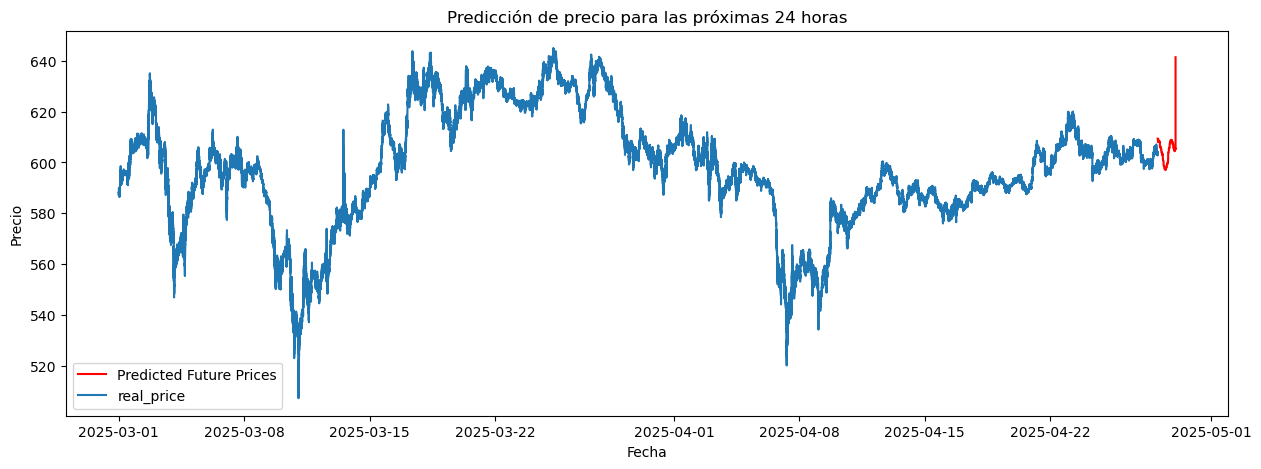

In [46]:
plt.figure(figsize=(15,5))
plt.plot(future_df['ds'], future_preds, label='Predicted Future Prices', color='r')
plt.plot(df['ds'], df['y'], label = 'real_price')
plt.title('Predicción de precio para las próximas 24 horas')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [48]:
predicted_prices = future_df.copy()
predicted_prices['Predicted Price'] = future_preds



In [50]:
predicted_prices[predicted_prices['ds']=='2025-04-28 07:10:00.999']

,ds,hour,minute,second,dayofweek,day,Predicted Price
25799,2025-04-28 07:10:00.999,7,10,0,0,28,600.878235


In [51]:
predicted_prices

,ds,hour,minute,second,dayofweek,day,Predicted Price
0,2025-04-28 00:00:01.999,0,0,1,0,28,609.364990
1,2025-04-28 00:00:02.999,0,0,2,0,28,609.364990
2,2025-04-28 00:00:03.999,0,0,3,0,28,609.364990
3,2025-04-28 00:00:04.999,0,0,4,0,28,609.364990
4,2025-04-28 00:00:05.999,0,0,5,0,28,609.364990
...,...,...,...,...,...,...,...
86395,2025-04-28 23:59:56.999,23,59,56,0,28,605.250305
86396,2025-04-28 23:59:57.999,23,59,57,0,28,605.250305
86397,2025-04-28 23:59:58.999,23,59,58,0,28,605.250305
86398,2025-04-28 23:59:59.999,23,59,59,0,28,605.250305
